# DDIM Inversion

## Setup

In [1]:
!pip install -q transformers diffusers accelerate matplotlib tqdm


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading an existing pipeline

In [3]:
# load pretrained checkpoint
pipe = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5').to(device)

# set up a DDIM scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

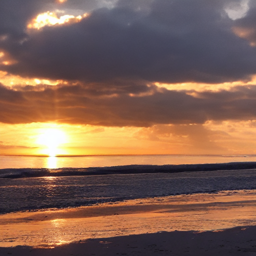

In [4]:
prompt = 'Beautiful DSLR Photograph of a pinguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256))

## DDIM Sampling

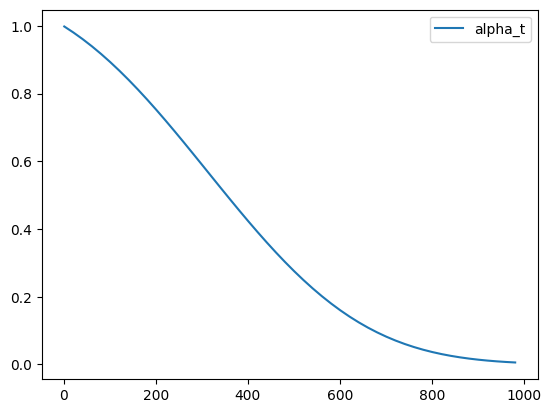

In [5]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t')
plt.legend()
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

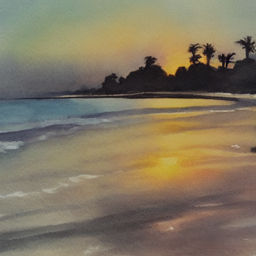

In [13]:
prompt = 'watercolor painting of a beach sunset'
num_images_per_prompt = 1
do_classifier_free_guidance = True
negative_prompt = ''
num_inference_steps = 30
start_latents = None
start_step = 0
guidance_scale = 3.5

# text encoder
text_embeddings = pipe._encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    do_classifier_free_guidance,
    negative_prompt
)

# set up inference steps
pipe.scheduler.set_timesteps(num_inference_steps, device)

# create a random starting point if we don't have one already
if start_latents is None:
    start_latents = torch.randn(1, 4, 64, 64, device=device)
    start_latents *= pipe.scheduler.init_noise_sigma
    
latents = start_latents.clone()

for i in tqdm(range(start_step, num_inference_steps)):
    
    t = pipe.scheduler.timesteps[i]
    
    # expande latents when enabling classifier free guidance (CFG)
    latent_input_model = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    
    # apply schduler's scaling on the input latents
    latent_input_model = pipe.scheduler.scale_model_input(latent_input_model, t)
    
    # predict noise residual
    with torch.inference_mode():
        noise_pred = pipe.unet(latent_input_model, t, encoder_hidden_states=text_embeddings).sample
        
    # apply classifier free guidance (CFG)
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
     
    # normally we would use scheduler.step to estiamte the latent at t-1
    # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    
    # instead, in this example we perform that step manually
    prev_t = max(1, t.item() - (1000//num_inference_steps))
    alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
    alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
    predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
    direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
    latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

# post-processing
with torch.inference_mode():
    images = pipe.decode_latents(latents)
images = pipe.numpy_to_pil(images)

images[0].resize((256, 256))

In [23]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device
):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

  0%|          | 0/50 [00:00<?, ?it/s]

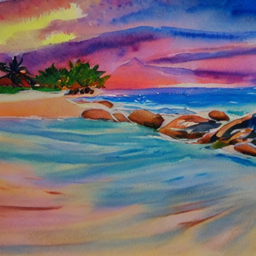

In [24]:
# Test our sampling function by generating an image
sample(
    'Watercolor painting of a beach sunset',
    negative_prompt=negative_prompt,
    num_inference_steps=50
)[0].resize((256, 256))

In [ ]:
print(latents.shape)
print(torch.cat([latents] * 2).shape)

In [ ]:
pipe.scheduler.init_noise_sigma

In [ ]:
pipe.scheduler.timesteps[29]

In [ ]:
34 - 1000//30

In [ ]:
list(reversed(range(1, 999, 33)))[1:]